<a href="https://colab.research.google.com/github/gmihaila/machine_learning_things/blob/master/learning_tensorflow/tf2_0_text_binary_classification_word_embed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Regular Classification [word embeedings]

In [0]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### Imports

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

BUFFER_SIZE = 1000
BATCH = 1000
EPOCHS = 20
MAX_LEN = 500

TensorFlow 2.x selected.
Num GPUs Available:  0


### Functions

In [0]:
def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return

#### Dataset

In [0]:
# Use the version pre-encoded with an ~8k vocabulary.
# Return the train/test datasets as a tuple.
# Return (example, label) pairs from the dataset (instead of a dictionary).
# Also return the `info` structure. 

(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', 
                                          split = (tfds.Split.TRAIN, tfds.Split.TEST),
                                          as_supervised=True,
                                          with_info=True)

text_encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(text_encoder.vocab_size))

# batch padding
train_batches = (train_data.shuffle(BUFFER_SIZE).padded_batch(BATCH, train_data.output_shapes))
test_batches = (test_data.padded_batch(BATCH, train_data.output_shapes))

# sample
encodings, labels = next(iter(train_batches))

print("Text:                  {}".format(text_encoder.decode(encodings[0])))
print("Encoding sample:       {}".format(encodings[0][:10]))
print("Label:                 {}".format(labels[0]))
print("Encoding batch shape:  {}".format(encodings.shape))
print("Labels batch shape:    {}".format(labels.shape))

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteVLV110/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteVLV110/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteVLV110/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
Vocabulary size: 8185
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Text:                  I guess I was attracted to this film both because of the sound of the story and the leading actor, so I gave it a chance, from director Gregor Jordan (Buffalo Soldiers). Basically Ned Kelly (Heath Ledger) is set up by the police, especially Superintendent Francis Hare (Geoffrey Rush), he is forced to go on the run forming a gang and go against them to clear his own and his family's names. That's really all I can say about the story, as I wasn't paying the fullest attention to be honest. Also starring Orlando Bloom as Joseph Byrne, Naomi Watts as Julia Cook, Laurence Kinlan as Dan Kelly, Philip Barantini as Steve Hart, Joel Edgerton as Aaron Sherritt, Kiri Paramore as Constable Fitzpatrick, Kerry Condon as Kate Kelly, Emily Browning as Grace Kelly and Rachel Griffiths as Susan Scott. Ledger makes a pretty good performance, for what it's worth, and the film does have it's eye-catching moments, particularly with a gun battle towards the end, but I can't say I enjoye

#### Sequential Model + regular train

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
25/25 [==============================] - 11s 447ms/step - loss: 0.6930 - accuracy: 0.5144 - val_loss: 0.6928 - val_accuracy: 0.5163
Epoch 2/20
25/25 [==============================] - 10s 411ms/step - loss: 0.6925 - accuracy: 0.5469 - va

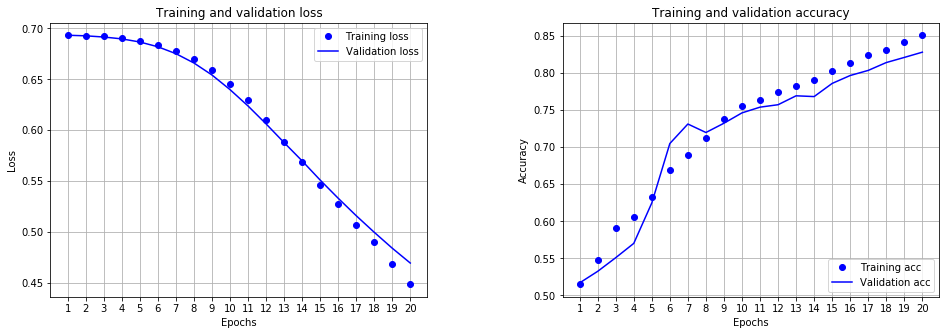

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(text_encoder.vocab_size, 16))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# use test as valid 
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=test_batches,
                    verbose=1)

results = model.evaluate(test_batches, verbose=2)

loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

plt_history(history_dict=history.history)

#### Sequential Model + gradient tape


**Notes:**

* Apply with logits if we apply optimizer to values coming form softmax
* if sequence varies, use funcion signature and specify exact tensor shape and dtype
* Specify Global Scope variables that will be used in functions

Epoch: 1/20	loss: 0.6931	acc: 0.5015	val_loss: 0.6931	val_acc: 0.5026
Epoch: 2/20	loss: 0.6930	acc: 0.5055	val_loss: 0.6929	val_acc: 0.5194
Epoch: 3/20	loss: 0.6927	acc: 0.5312	val_loss: 0.6924	val_acc: 0.5338
Epoch: 4/20	loss: 0.6920	acc: 0.5382	val_loss: 0.6914	val_acc: 0.5454
Epoch: 5/20	loss: 0.6905	acc: 0.5527	val_loss: 0.6896	val_acc: 0.5563
Epoch: 6/20	loss: 0.6880	acc: 0.5615	val_loss: 0.6864	val_acc: 0.5661
Epoch: 7/20	loss: 0.6836	acc: 0.5719	val_loss: 0.6813	val_acc: 0.5785
Epoch: 8/20	loss: 0.6769	acc: 0.5854	val_loss: 0.6737	val_acc: 0.5921
Epoch: 9/20	loss: 0.6676	acc: 0.5991	val_loss: 0.6631	val_acc: 0.6058
Epoch: 10/20	loss: 0.6544	acc: 0.6123	val_loss: 0.6498	val_acc: 0.6183
Epoch: 11/20	loss: 0.6389	acc: 0.6239	val_loss: 0.6340	val_acc: 0.6293
Epoch: 12/20	loss: 0.6196	acc: 0.6346	val_loss: 0.6161	val_acc: 0.6398
Epoch: 13/20	loss: 0.6000	acc: 0.6448	val_loss: 0.5976	val_acc: 0.6493
Epoch: 14/20	loss: 0.5783	acc: 0.6538	val_loss: 0.5786	val_acc: 0.6582
Epoch: 15/20	lo

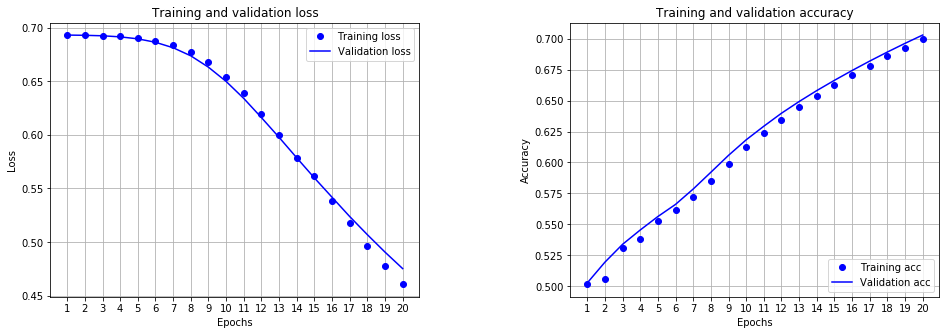

In [0]:
class Classification(tf.keras.Model):
  def __init__(self, vocab_size, emb_size):
    super(Classification, self).__init__()
    self.emb_layer = tf.keras.layers.Embedding(vocab_size, emb_size)
    self.avg_layer = tf.keras.layers.GlobalAveragePooling1D()
    self.l1 = tf.keras.layers.Dense(units=16, activation=tf.nn.relu)
    self.l2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
    return

  def call(self, input_batch):
    intermediate_value = self.emb_layer(input_batch)
    intermediate_value = self.avg_layer(intermediate_value)
    intermediate_value = self.l1(intermediate_value)
    output_batch = self.l2(intermediate_value)
    return output_batch


def loss_func(target, logits):
  bce = tf.losses.BinaryCrossentropy(from_logits=False)
  return bce(y_true=target, y_pred=logits)

# need signature becuase each batch different shape
@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, None], dtype=tf.int64),
    tf.TensorSpec(shape=[None,], dtype=tf.int64)])
def train_step(input_batch, label_batch):
  # use global scope variables
  global model, model_optimizer
  loss = 0
  with tf.GradientTape() as tape:
    preds_batch = model(input_batch)
    loss = loss_func(label_batch, preds_batch)

  variables = model.variables
  gradients = tape.gradient(loss, variables)
  model_optimizer.apply_gradients(zip(gradients, variables))
  return loss

history_dict = {'accuracy':[],
                'val_accuracy':[], 
                'loss':[], 
                'val_loss':[]}

# global scope variables
model = Classification(vocab_size=text_encoder.vocab_size, emb_size=16)
model_optimizer = tf.optimizers.Adam()
model_metrics = tf.metrics.Accuracy()

EPOCHS = 20

for epoch in range(EPOCHS):
  batch_loss = 0
  batch_val_loss = 0

  batch_acc = 0
  batch_val_acc = 0

  for batch, (text_batch, label_batch) in enumerate(train_batches, start=1):
    batch_loss += train_step(text_batch, label_batch)

    preds_batch = model(text_batch)
    preds_batch = tf.keras.backend.round(preds_batch)
    batch_acc += model_metrics(label_batch, preds_batch) 

  batch_loss = tf.get_static_value(batch_loss) / batch
  history_dict['loss'].append(batch_loss)

  batch_acc = tf.get_static_value(batch_acc) / batch
  history_dict['accuracy'].append(batch_acc)
  

  for batch, (text_batch, label_batch) in enumerate(test_batches, start=1):
    preds_batch = model(text_batch)
    batch_val_loss += loss_func(label_batch, preds_batch)

    preds_batch = tf.keras.backend.round(preds_batch)
    batch_val_acc += model_metrics(label_batch, preds_batch) 

  
  batch_val_loss = tf.get_static_value(batch_val_loss) / batch
  history_dict['val_loss'].append(batch_val_loss)

  batch_val_acc =tf.get_static_value(batch_val_acc) / batch
  history_dict['val_accuracy'].append(batch_val_acc)

  print('Epoch: %s/%s\tloss: %.4f\tacc: %.4f\tval_loss: %.4f\tval_acc: %.4f'%(epoch+1, EPOCHS, batch_loss, batch_acc, batch_val_loss, batch_val_acc))

plt_history(history_dict)

#### Separate Models + gradient tape

Epoch: 1/20	loss: 0.6936	acc: 0.4994	val_loss: 0.6931	val_acc: 0.5005
Epoch: 2/20	loss: 0.6932	acc: 0.4999	val_loss: 0.6931	val_acc: 0.4998
Epoch: 3/20	loss: 0.6932	acc: 0.5000	val_loss: 0.6931	val_acc: 0.5000
Epoch: 4/20	loss: 0.6931	acc: 0.5007	val_loss: 0.6931	val_acc: 0.5011
Epoch: 5/20	loss: 0.6931	acc: 0.5009	val_loss: 0.6931	val_acc: 0.5012
Epoch: 6/20	loss: 0.6931	acc: 0.5011	val_loss: 0.6931	val_acc: 0.5014
Epoch: 7/20	loss: 0.6931	acc: 0.5026	val_loss: 0.6931	val_acc: 0.5032
Epoch: 8/20	loss: 0.6930	acc: 0.5044	val_loss: 0.6930	val_acc: 0.5054
Epoch: 9/20	loss: 0.6930	acc: 0.5065	val_loss: 0.6929	val_acc: 0.5075
Epoch: 10/20	loss: 0.6928	acc: 0.5083	val_loss: 0.6927	val_acc: 0.5092
Epoch: 11/20	loss: 0.6925	acc: 0.5103	val_loss: 0.6924	val_acc: 0.5110
Epoch: 12/20	loss: 0.6920	acc: 0.5121	val_loss: 0.6916	val_acc: 0.5133
Epoch: 13/20	loss: 0.6907	acc: 0.5145	val_loss: 0.6898	val_acc: 0.5159
Epoch: 14/20	loss: 0.6878	acc: 0.5180	val_loss: 0.6858	val_acc: 0.5208
Epoch: 15/20	lo

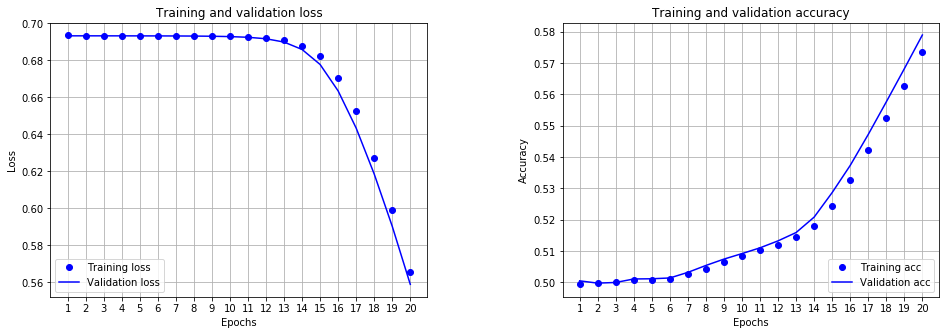

In [0]:
class Embed(tf.keras.Model):
  def __init__(self, vocab_size, emb_size):
    super(Embed, self).__init__()
    self.emb_layer = tf.keras.layers.Embedding(vocab_size, emb_size)
    self.avg_layer = tf.keras.layers.GlobalAveragePooling1D()
    return

  def call(self, input_batch):
    output_batch = self.emb_layer(input_batch)
    output_batch = self.avg_layer(intermediate_value)
    return output_batch

class Dens(tf.keras.Model):
  def __init__(self):
    super(Dens, self).__init__()
    self.l1 = tf.keras.layers.Dense(units=16, activation=tf.nn.relu)
    self.l2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
    return

  def call(self, input_batch):
    intermediate_value = self.l1(input_batch)
    output_batch = self.l2(intermediate_value)
    return output_batch


def loss_func(target, logits):
  bce = tf.losses.BinaryCrossentropy(from_logits=False)
  return bce(y_true=target, y_pred=logits)


# need signature becuase each batch different shape
@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, None], dtype=tf.int64),
    tf.TensorSpec(shape=[None,], dtype=tf.int64)])
def train_step(input_batch, lables_batch):
  loss = 0
  # use global scope variables
  global model_embed, model_dens, model_optimizer
  with tf.GradientTape() as tape:
    preds_batch = model_embed(input_batch)
    preds_batch = model_dens(preds_batch)

    loss = loss_func(lables_batch, preds_batch)

  variables = model_embed.variables + model_dens.variables
  gradients = tape.gradient(loss, variables)
  model_optimizer.apply_gradients(zip(gradients, variables))
  return loss



# global scope variables
model_embed = Classification(vocab_size=text_encoder.vocab_size, emb_size=16)
model_dens = Dens()
model_optimizer = tf.optimizers.Adam()
model_metrics = tf.metrics.Accuracy()

history_dict = {'accuracy':[],
                'val_accuracy':[], 
                'loss':[], 
                'val_loss':[]}

EPOCHS = 20

for epoch in range(EPOCHS):
  batch_loss = 0
  batch_val_loss = 0

  batch_acc = 0
  batch_val_acc = 0

  for batch, (text_batch, label_batch) in enumerate(train_batches, start=1):
    batch_loss += train_step(text_batch, label_batch)

    preds_batch = model_embed(text_batch)
    preds_batch = model_dens(preds_batch)

    preds_batch = tf.keras.backend.round(preds_batch)
    batch_acc += model_metrics(label_batch, preds_batch) 

  batch_loss = tf.get_static_value(batch_loss) / batch
  history_dict['loss'].append(batch_loss)

  batch_acc = tf.get_static_value(batch_acc) / batch
  history_dict['accuracy'].append(batch_acc)

  for batch, (text_batch, label_batch) in enumerate(test_batches, start=1):
    preds_batch = model_embed(text_batch)
    preds_batch = model_dens(preds_batch)

    batch_val_loss += loss_func(label_batch, preds_batch)

    preds_batch = tf.keras.backend.round(preds_batch)
    batch_val_acc += model_metrics(label_batch, preds_batch) 

  
  batch_val_loss = tf.get_static_value(batch_val_loss) / batch
  history_dict['val_loss'].append(batch_val_loss)

  batch_val_acc =tf.get_static_value(batch_val_acc) / batch
  history_dict['val_accuracy'].append(batch_val_acc)

  print('Epoch: %s/%s\tloss: %.4f\tacc: %.4f\tval_loss: %.4f\tval_acc: %.4f'%(epoch+1, EPOCHS, batch_loss, batch_acc, batch_val_loss, batch_val_acc))
    
plt_history(history_dict)